### Standford Cars Vehicle Recognition - ResNet34 w/ fastai ROUGH DRAFT

### Due to computation limitations, the notebook kernel was restarted after each training phase (a lot of RAM and kernel errors/crashes). Models trained were saved and loaded back to continue the training. I was not able to save some of the outputs but some of the saved outputs are attached via Ipython.display.Image function.

### CODE ONLY, For a detailed report, please refer to the Final Report

#### by Sean Sungil Kim

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from glob import iglob
from IPython.core.display import Image, display
import cv2
import time

# custom python scripts
import SC_sungil             # preprocessing

In [3]:
#SC_sungil.test_to_train(22)
#SC_sungil.from_fold_und_smpl_reset()
#SC_sungil.from_fold_und_smpl()

data_dir = '/home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und/'
data_path = Path(data_dir)

img_data_list = os.listdir(data_dir + 'train')
class_num = len(img_data_list)
print('There are total %i classes in the Vehicle-detected Stanford Cars Dataset' % (class_num))

There are total 189 classes in the Vehicle-detected Stanford Cars Dataset


In [4]:
x_tot = np.zeros(3)
x2_tot = np.zeros(3)
cnt = 0

for img_path in iglob(data_dir + 'train/*/*.jpg'):
    imagearray = cv2.imread(img_path).reshape(-1,3)/255.
    x_tot += imagearray.mean(axis = 0)
    x2_tot += (imagearray**2).mean(axis=0)
    cnt += 1
    
channel_avr = x_tot/cnt
channel_std = np.sqrt(x2_tot/cnt - channel_avr**2)
channel_avr, channel_std

(array([0.403171, 0.401802, 0.422073]), array([0.291696, 0.287418, 0.291519]))

In [5]:
data = ImageDataBunch.from_folder(data_path, train = 'train', valid = 'test',\
            ds_tfms = get_transforms(do_flip = True, flip_vert = False, max_rotate = 90), size = 224,\
            bs = 64, num_workers = 0).normalize([tensor(channel_avr.tolist()), tensor(channel_std.tolist())])
data

ImageDataBunch;

Train: LabelList (8694 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und;

Valid: LabelList (3883 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und;

Test: None

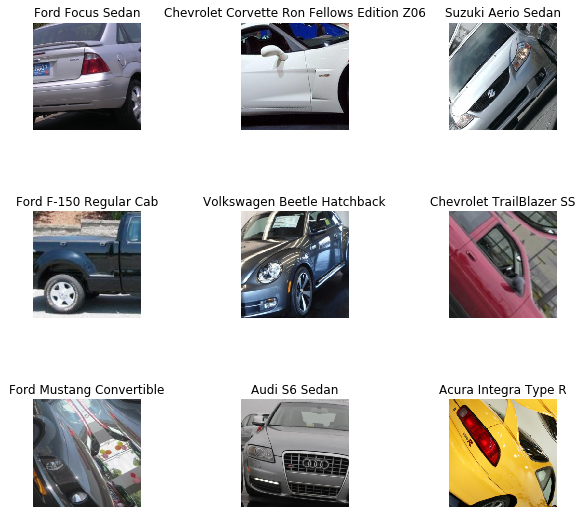

In [15]:
# preview of training data generated from ImageDataBunch
data.show_batch(rows = 3, figsize = (8, 8))

In [16]:
# first 5 class labels obtained from the class-folder names
print(data.classes[:5])

['AM General Hummer SUV', 'Acura Integra Type R', 'Acura RL Sedan', 'Acura TL Sedan', 'Acura TL Type-S']


In [6]:
# loading the pre-trained ResNet34 cnn
learn = cnn_learner(data, models.resnet34, pretrained = True, metrics = accuracy, callback_fns = ShowGraph,\
                    model_dir = "/home/ec2-user/")
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

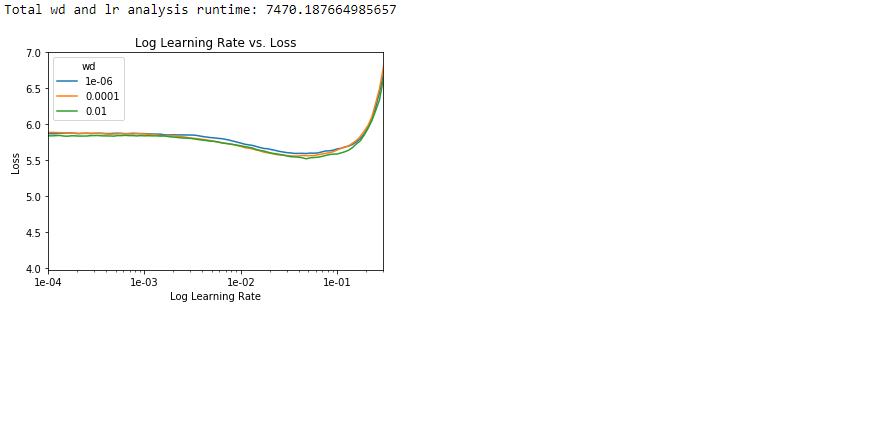

In [6]:
lr_List = []
loss_List = []
wd_List = [1e-6, 1e-4, 1e-2]

start_ts = time.time()
for wd in wd_List:
    exp_learn = cnn_learner(data, models.resnet34, pretrained = True, metrics = accuracy, model_dir = "/tmp/exp/model/")
    exp_learn.lr_find(wd = wd, num_it = 200)
    lr_List.append(exp_learn.recorder.lrs)
    loss_List.append(exp_learn.recorder.losses)

min_y = 4
max_y = 7
_, ax = plt.subplots(1, 1)
for i in range(len(loss_List)):
    ax.plot(lr_List[i], loss_List[i])
    min_y = min(np.asarray(loss_List[i]).min(), min_y)
ax.set_title('Log Learning Rate vs. Loss'), ax.set_ylabel('Loss'), ax.set_xlabel('Log Learning Rate')
ax.set_xscale('log'), ax.set_xlim((1e-4,3e-1)), ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wd_List, title = 'wd'), ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
print("\nTotal wd and lr analysis runtime:", time.time() - start_ts)
#display(Image(filename = 'outputs/fastai/lrfinder1.png'))

In [ ]:
learn.fit_one_cycle(10, max_lr = 1e-2, wd = 1e-2)

In [ ]:
learn.recorder.plot()

In [ ]:
learn.save('/home/ec2-user/ResNet34_phase1.h5', return_path = True)

In [ ]:
learn = learn.load('/home/ec2-user/ResNet34_phase1.h5')

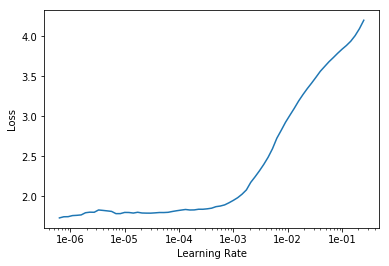

In [7]:
learn.unfreeze()
learn.lr_find(wd = 1e-2)
#display(Image(filename = 'outputs/fastai/lrfinder2.png'))

In [ ]:
learn.recorder.plot()

In [ ]:
learn.summary()

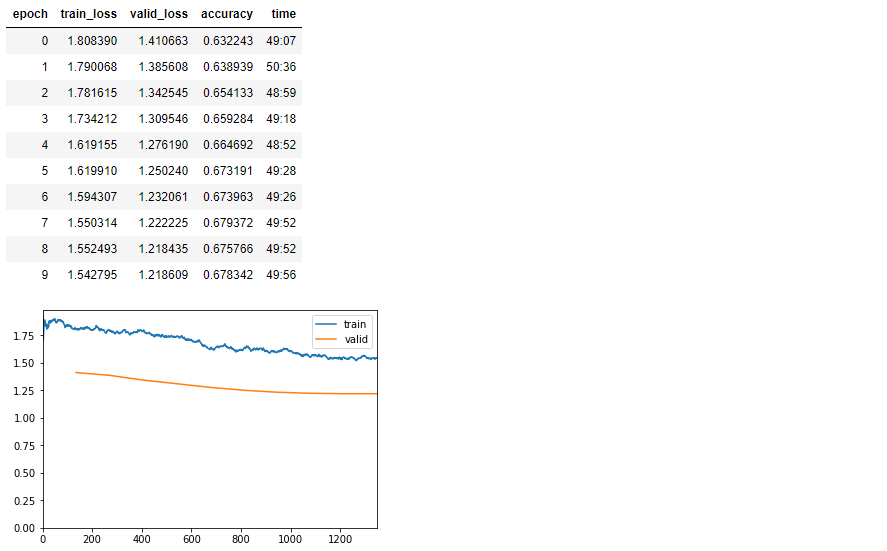

In [4]:
learn.fit_one_cycle(10, max_lr = slice(4e-6, 4e-5), wd = 1e-2)
#display(Image(filename = 'outputs/fastai/hypertuned output1.png'))

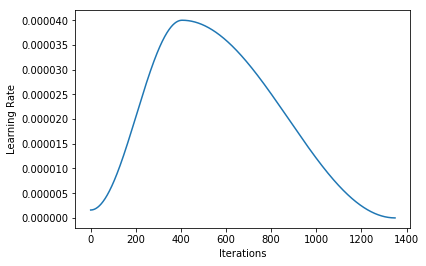

In [5]:
learn.recorder.plot_lr()
#display(Image(filename = 'outputs/fastai/hypertuned lr vs iterations1.png'))

In [ ]:
learn.save('/home/ec2-user/ResNet34_phase2.h5', return_path = True)

In [7]:
learn = learn.load('/home/ec2-user/ResNet34_phase2.h5')
learn.unfreeze()
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

epoch,train_loss,valid_loss,accuracy,time
0,1.557081,1.216002,0.675251,14:58
1,1.545179,1.204483,0.681689,14:48
2,1.564081,1.192634,0.684522,14:51
3,1.465772,1.171620,0.688643,26:22
4,1.483997,1.156955,0.693021,47:19
5,1.449640,1.131565,0.704095,48:21
6,1.440592,1.117790,0.703580,46:59
7,1.400102,1.112542,0.704095,49:10
8,1.384001,1.101945,0.708215,47:01
9,1.410389,1.102118,0.707443,48:00


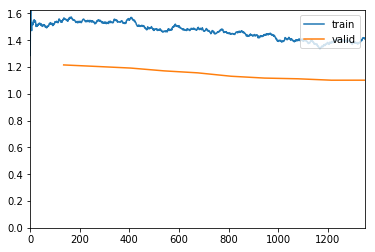

In [8]:
learn.fit_one_cycle(10, max_lr = slice(4e-6, 4e-5), wd = 1e-2)

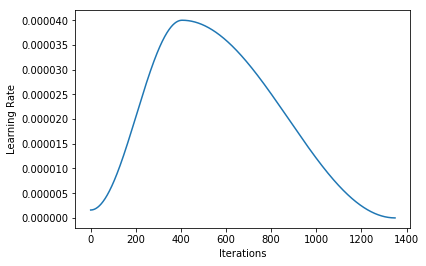

In [9]:
learn.recorder.plot_lr()

In [10]:
learn.save('/home/ec2-user/ResNet34_phase3.h5', return_path = True)

PosixPath('/home/ec2-user/ResNet34_phase3.h5.pth')

In [11]:
val_preds, val_targets = learn.get_preds()
preds = val_preds.tolist()
cls_preds = np.array([pred.index(max(pred))for pred in preds])
precision, recall, fscore, support = precision_recall_fscore_support(np.array(val_targets), cls_preds, average = 'weighted')
print('The precision score is', precision, '\nThe recall score is', recall, '\nThe fscore score is', fscore)

The precision score is 0.7308741462184829 
The recall score is 0.7074426989441154 
The fscore score is 0.7070709220886003


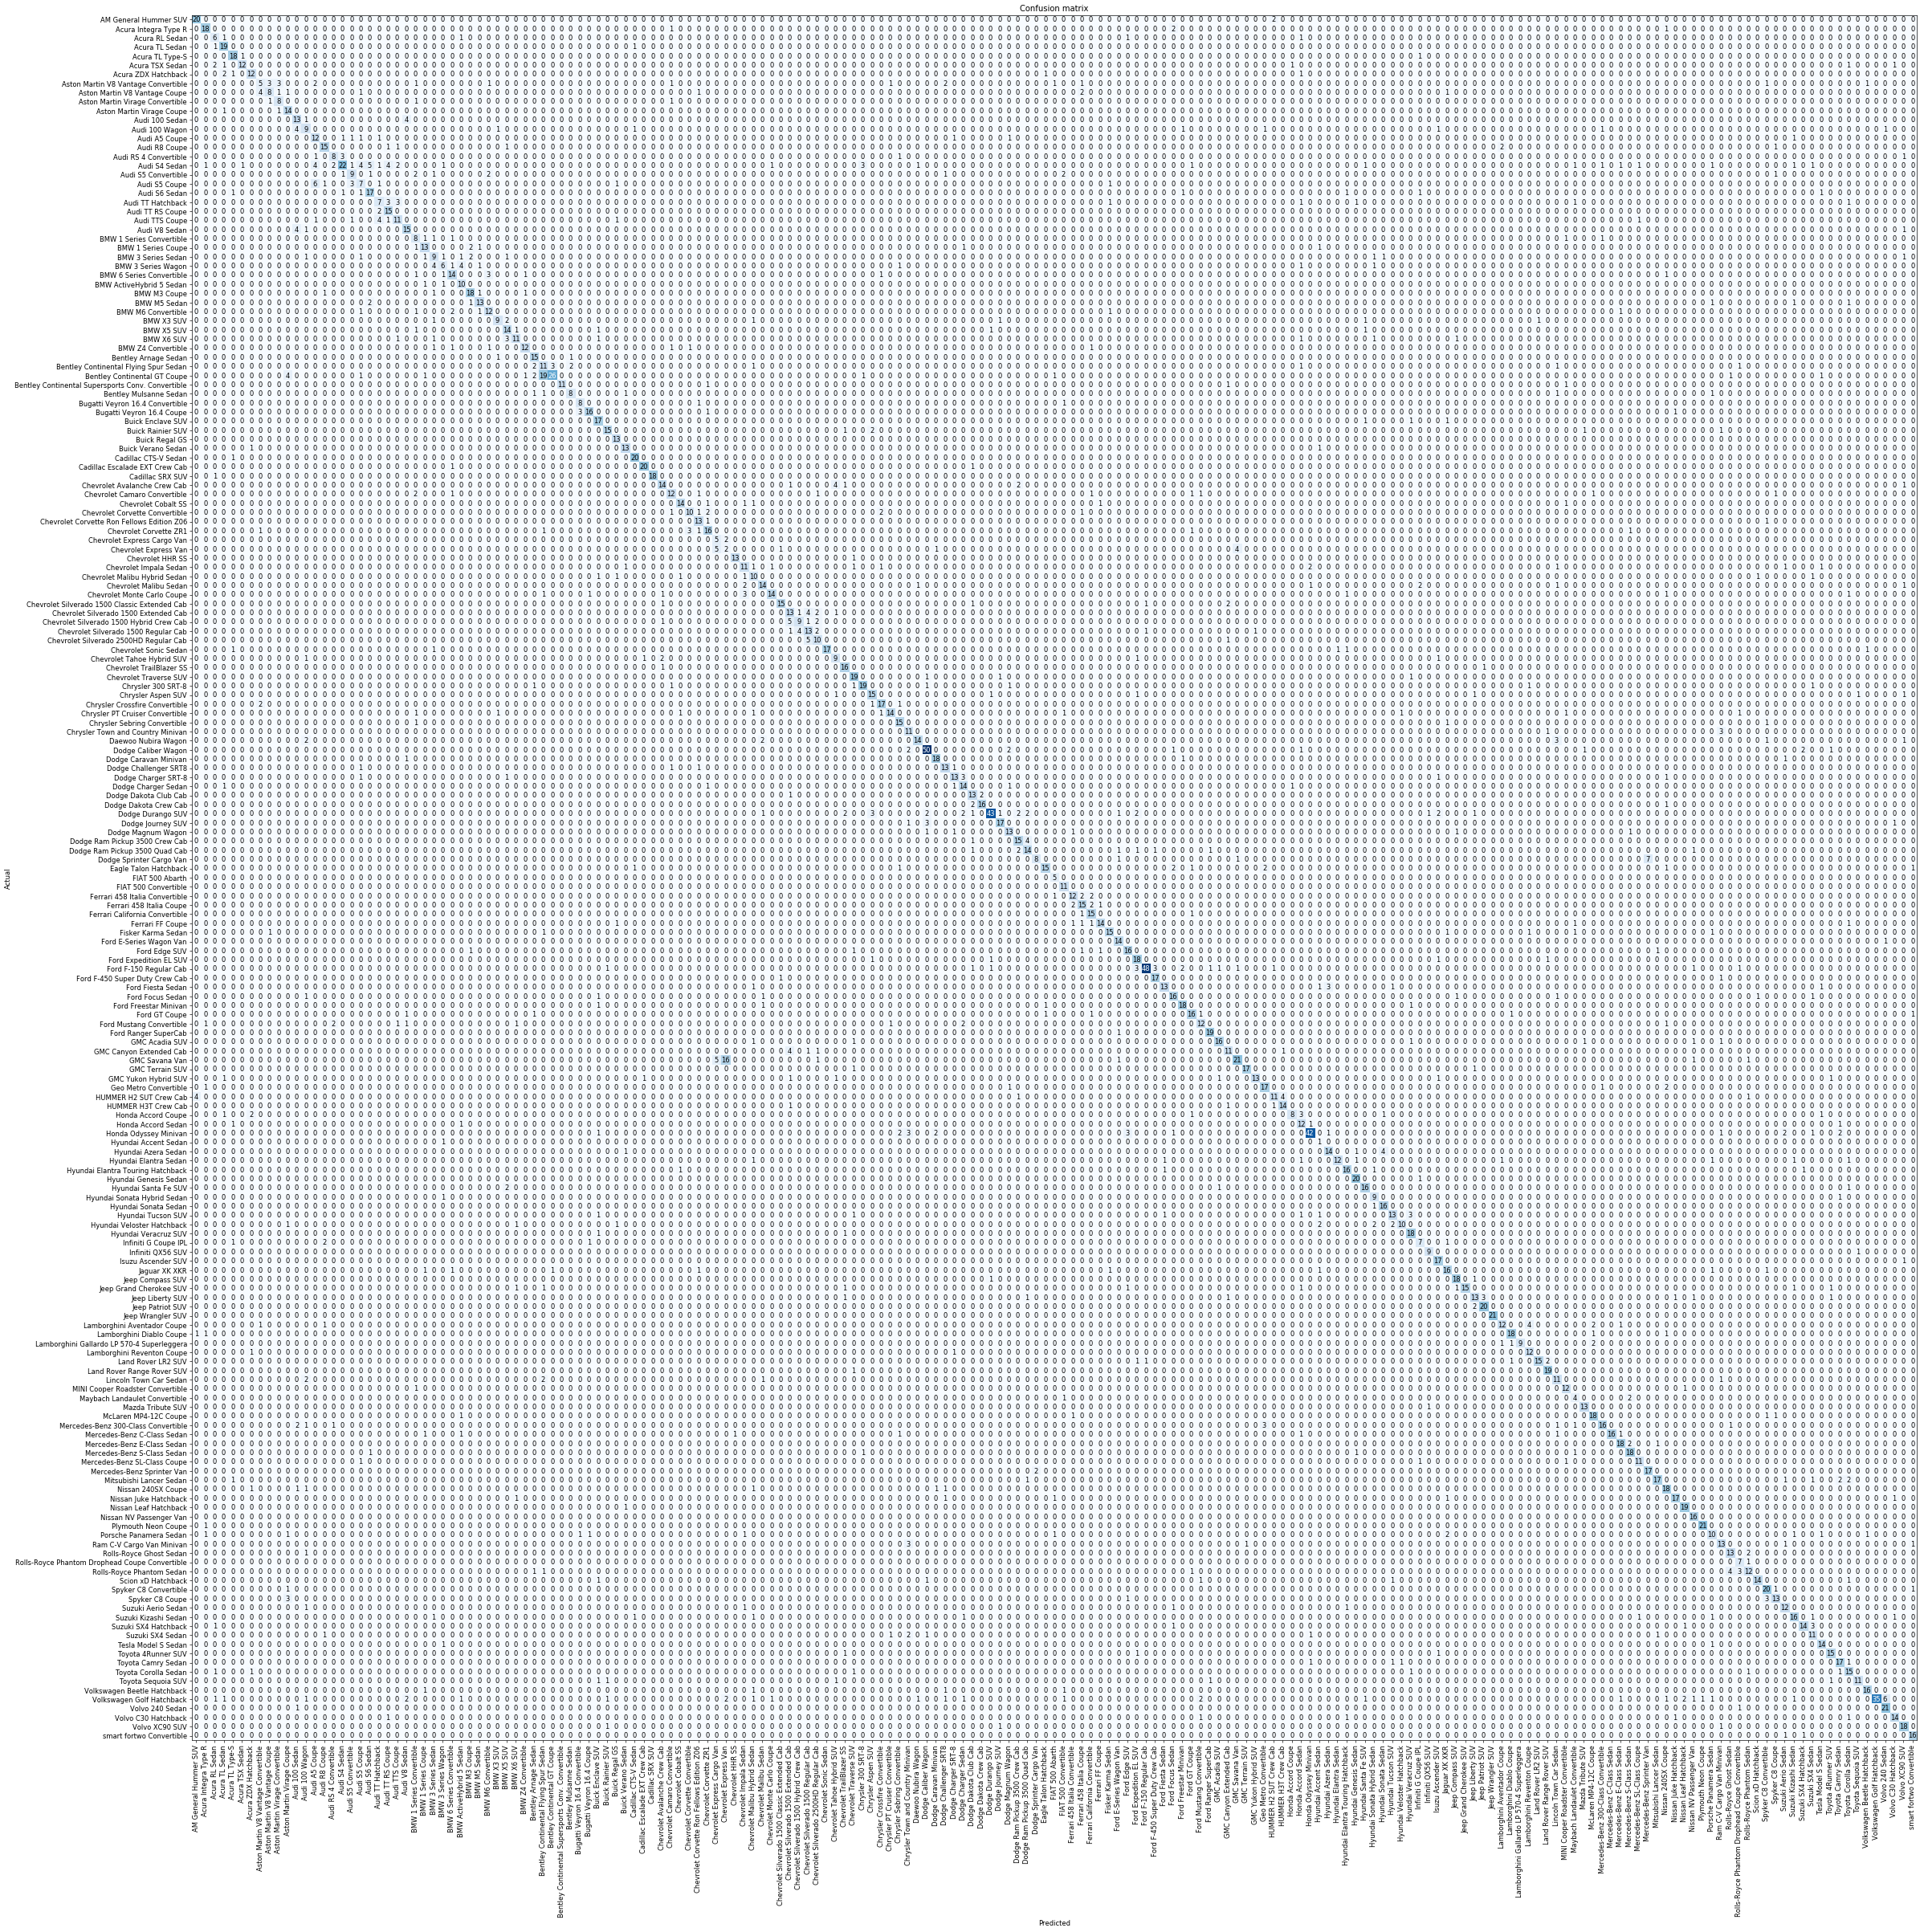

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (40, 40), dpi = 60)

In [13]:
#losses, idxs = interp.top_losses()
interp.most_confused(min_val = 5)

[('Bentley Continental GT Coupe', 'Bentley Continental Flying Spur Sedan', 19),
 ('GMC Savana Van', 'Chevrolet Express Van', 16),
 ('Dodge Sprinter Cargo Van', 'Mercedes-Benz Sprinter Van', 7),
 ('Audi S5 Coupe', 'Audi A5 Coupe', 6),
 ('Volkswagen Golf Hatchback', 'Volvo 240 Sedan', 6),
 ('Audi S4 Sedan', 'Audi S6 Sedan', 5),
 ('Chevrolet Express Van', 'Chevrolet Express Cargo Van', 5),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab',
  'Chevrolet Silverado 1500 Extended Cab',
  5),
 ('Chevrolet Silverado 2500HD Regular Cab',
  'Chevrolet Silverado 1500 Regular Cab',
  5),
 ('GMC Savana Van', 'Chevrolet Express Cargo Van', 5)]

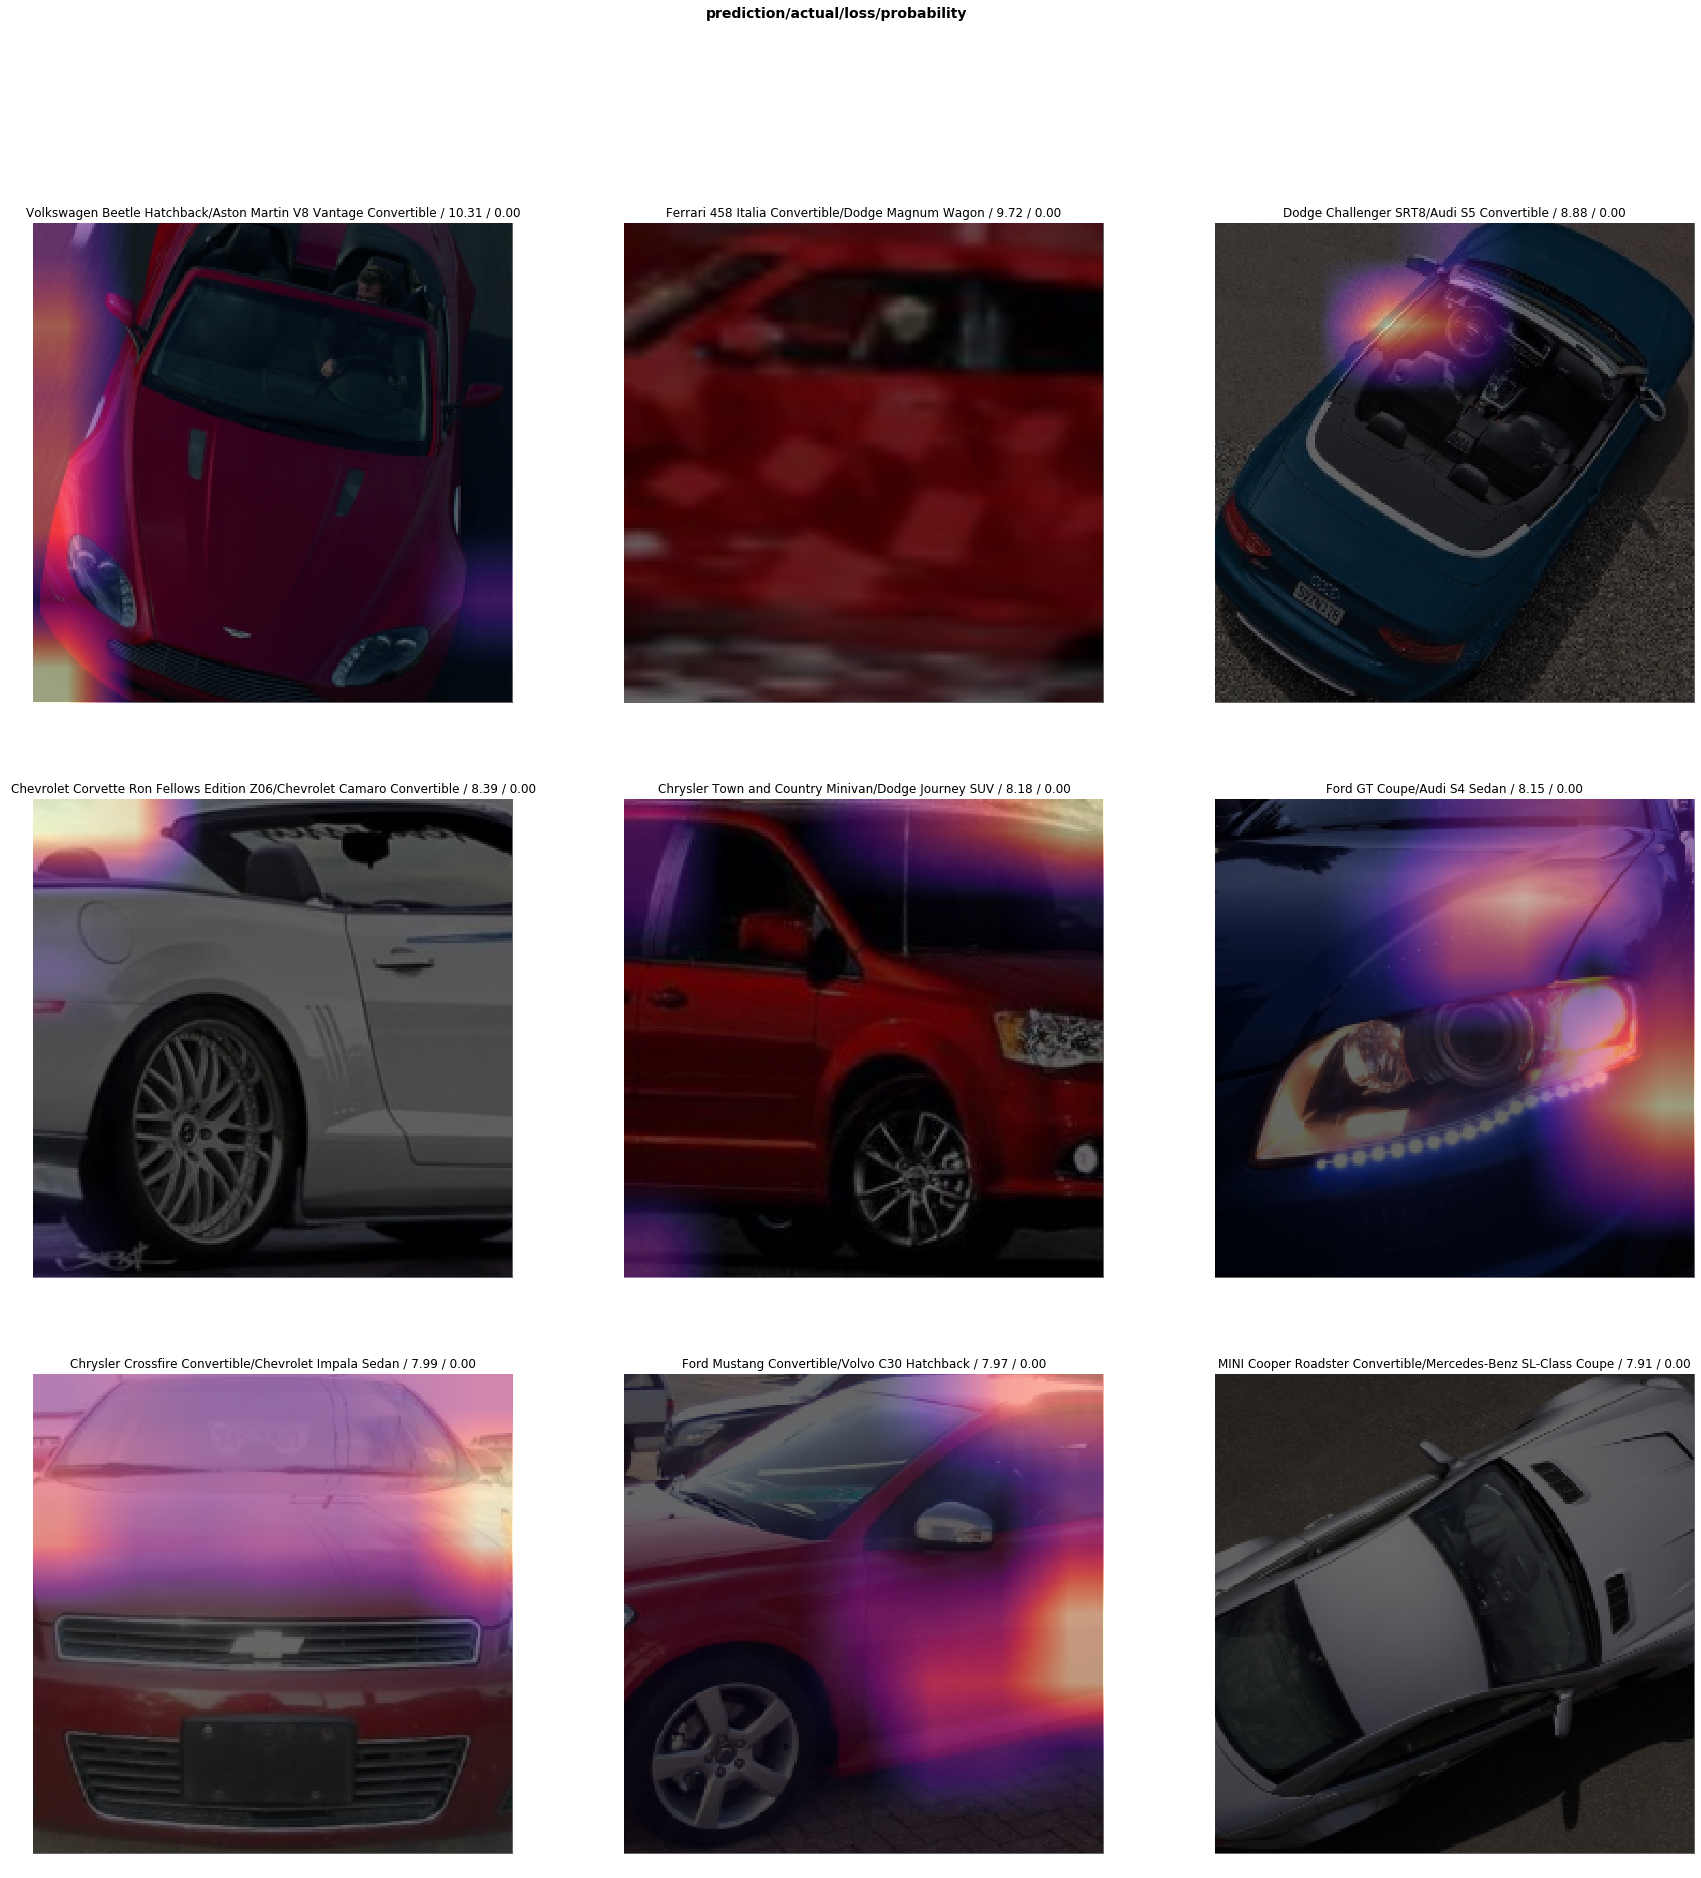

In [14]:
interp.plot_top_losses(9, figsize = (30, 30))